# Práctica de Laboratorio de Procesamiento del Lenguaje Natural (NLP)

Tema: Clustering Jerárquico

## Objetivo de la práctica

El objetivo de esta práctica es procesar los datos de entrada dados en el "corpus", con el objetivo de ejecutar clustering jerárquico (utilizando `AgglomerativeClustering`) para comprobar los resultados.

In [33]:
import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt

pd.options.display.max_colwidth = 200
%matplotlib inline

In [34]:
corpus = ['El cielo es azul y luminoso.',
          '¡Me encanta este cielo azul y luminoso!',
          'El zorro marrón es rápido y salta sobre el perro que es dormilón.',
          'Un desayuno real tiene salchichas, jamón, bacon, huevos, tostadas y queso',
          '¡Me encanta el jamón, los huevos, las salchichas y el bacon!',
          '¡El zorro marrón es rápido, y el perro azul es un dormilón!',
          'El cielo es azul intenso y hoy está muy luminoso',
          '¡El perro es un dormilón, pero el zorro es mu rápido!'
]
labels = ['tiempo', 'tiempo', 'animales', 'alimentos', 'alimentos', 'animales', 'tiempo', 'animales']

corpus = np.array(corpus)
corpus_df = pd.DataFrame({'Documento': corpus,
                           'Categoria': labels}) 
corpus_df = corpus_df[['Documento', 'Categoria']]

corpus_df

,Documento,Categoria
0,El cielo es azul y luminoso.,tiempo
1,¡Me encanta este cielo azul y luminoso!,tiempo
2,El zorro marrón es rápido y salta sobre el perro que es dormilón.,animales
3,"Un desayuno real tiene salchichas, jamón, bacon, huevos, tostadas y queso",alimentos
4,"¡Me encanta el jamón, los huevos, las salchichas y el bacon!",alimentos
5,"¡El zorro marrón es rápido, y el perro azul es un dormilón!",animales
6,El cielo es azul intenso y hoy está muy luminoso,tiempo
7,"¡El perro es un dormilón, pero el zorro es mu rápido!",animales


# Pre-procesamiento

Para poder clusterizar los textos con mayor facilidad, es necesario que se queden las palabras que contengan significado de cada texto. Por ello, preprocesa los textos para eliminar los caracteres especiales, unificarlo en minúsculas, eliminar espacios extra (utiliza `strip()` para esto) y eliminar las stopwords.

In [35]:
wpt = nltk.WordPunctTokenizer()
stop_words = nltk.corpus.stopwords.words('spanish')

def normalize_document(doc):
    doc = doc.replace("!", "").replace("¡", "").replace(",", "").replace(".", "")
    doc = doc.lower()
    doc = doc.strip()
    # tokenize document
    tokens = wpt.tokenize(doc)
    # filter stopwords out of document
    filtered_tokens = [token for token in tokens if token not in stop_words]
    # re-create document from filtered tokens
    doc = ' '.join(filtered_tokens)
    return doc


In [53]:
# Guardar función en un archivo .py
with open('mis_funciones.py', 'w') as f:
    f.write("""
from nltk.tokenize import WordPunctTokenizer
from nltk.corpus import stopwords

wpt = WordPunctTokenizer()
stop_words = set(stopwords.words('spanish'))

def normalize_document(doc):
    doc = doc.replace("!", "").replace("¡", "").replace(",", "").replace(".", "")
    doc = doc.lower()
    doc = doc.strip()
    # tokenize document
    tokens = wpt.tokenize(doc)
    # filter stopwords out of document
    filtered_tokens = [token for token in tokens if token not in stop_words]
    # re-create document from filtered tokens
    doc = ' '.join(filtered_tokens)
    return doc
""")


In [36]:
norm_corpus=[]

for document in corpus:
    norm_corpus.append(normalize_document(document))

norm_corpus

['cielo azul luminoso',
 'encanta cielo azul luminoso',
 'zorro marrón rápido salta perro dormilón',
 'desayuno real salchichas jamón bacon huevos tostadas queso',
 'encanta jamón huevos salchichas bacon',
 'zorro marrón rápido perro azul dormilón',
 'cielo azul intenso hoy luminoso',
 'perro dormilón zorro mu rápido']

# Generación de las matrices

Genera BOW, TFIDF & Bag Of N-grams; se utilizarán para comparar los resultados.

In [37]:
from sklearn.feature_extraction.text import CountVectorizer
# get bag of words features in sparse format
cv = CountVectorizer(min_df=0., max_df=1.)
cv_matrix = cv.fit_transform(norm_corpus)
cv_matrix

<8x21 sparse matrix of type '<class 'numpy.int64'>'
	with 42 stored elements in Compressed Sparse Row format>

In [38]:
# view dense representation 
# warning might give a memory error if data is too big
cv_matrix = cv_matrix.toarray()
cv_matrix

array([[1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1],
       [0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0],
       [0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1],
       [1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1]])

In [39]:
# get all unique words in the corpus
vocab = cv.get_feature_names_out()
# show document feature vectors
pd.DataFrame(cv_matrix, columns=vocab)

,azul,bacon,cielo,desayuno,dormilón,encanta,hoy,huevos,intenso,jamón,...,marrón,mu,perro,queso,real,rápido,salchichas,salta,tostadas,zorro
0,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,1,0,0,0,0,0,...,1,0,1,0,0,1,0,1,0,1
3,0,1,0,1,0,0,0,1,0,1,...,0,0,0,1,1,0,1,0,1,0
4,0,1,0,0,0,1,0,1,0,1,...,0,0,0,0,0,0,1,0,0,0
5,1,0,0,0,1,0,0,0,0,0,...,1,0,1,0,0,1,0,0,0,1
6,1,0,1,0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,1,0,0,0,0,0,...,0,1,1,0,0,1,0,0,0,1


# Bag of N-Grams Model

In [40]:
# you can set the n-gram range to 1,2 to get unigrams as well as bigrams
bv = CountVectorizer(ngram_range=(2,2))
bv_matrix = bv.fit_transform(norm_corpus)

bv_matrix = bv_matrix.toarray()
vocab = bv.get_feature_names_out()
pd.DataFrame(bv_matrix, columns=vocab)

,azul dormilón,azul intenso,azul luminoso,bacon huevos,cielo azul,desayuno real,dormilón zorro,encanta cielo,encanta jamón,hoy luminoso,...,perro dormilón,real salchichas,rápido perro,rápido salta,salchichas bacon,salchichas jamón,salta perro,tostadas queso,zorro marrón,zorro mu
0,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,1,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,1,0,0,1,0,0,1,0,1,0
3,0,0,0,1,0,1,0,0,0,0,...,0,1,0,0,0,1,0,1,0,0
4,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
5,1,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
6,0,1,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,1


# TF-IDF Model

In [41]:
from sklearn.feature_extraction.text import TfidfTransformer

tt = TfidfTransformer(norm='l2', use_idf=True, smooth_idf=True)
tt_matrix = tt.fit_transform(cv_matrix)

tt_matrix = tt_matrix.toarray()
vocab = cv.get_feature_names_out()
pd.DataFrame(np.round(tt_matrix, 2), columns=vocab)

,azul,bacon,cielo,desayuno,dormilón,encanta,hoy,huevos,intenso,jamón,...,marrón,mu,perro,queso,real,rápido,salchichas,salta,tostadas,zorro
0,0.53,0.00,0.60,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,0.43,0.00,0.49,0.00,0.00,0.57,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,0.00,0.00,0.00,0.00,0.37,0.00,0.00,0.00,0.00,0.00,...,0.43,0.00,0.37,0.00,0.00,0.37,0.00,0.51,0.00,0.37
3,0.00,0.32,0.00,0.38,0.00,0.00,0.00,0.32,0.00,0.32,...,0.00,0.00,0.00,0.38,0.38,0.00,0.32,0.00,0.38,0.00
4,0.00,0.45,0.00,0.00,0.00,0.45,0.00,0.45,0.00,0.45,...,0.00,0.00,0.00,0.00,0.00,0.00,0.45,0.00,0.00,0.00
5,0.35,0.00,0.00,0.00,0.40,0.00,0.00,0.00,0.00,0.00,...,0.47,0.00,0.40,0.00,0.00,0.40,0.00,0.00,0.00,0.40
6,0.34,0.00,0.39,0.00,0.00,0.00,0.54,0.00,0.54,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
7,0.00,0.00,0.00,0.00,0.41,0.00,0.00,0.00,0.00,0.00,...,0.00,0.57,0.41,0.00,0.00,0.41,0.00,0.00,0.00,0.41


In [42]:
from sklearn.feature_extraction.text import TfidfVectorizer

tv = TfidfVectorizer(min_df=0., max_df=1., norm='l2',
                     use_idf=True, smooth_idf=True)
tv_matrix = tv.fit_transform(norm_corpus)
tv_matrix = tv_matrix.toarray()

vocab = tv.get_feature_names_out()
pd.DataFrame(np.round(tv_matrix, 2), columns=vocab)

,azul,bacon,cielo,desayuno,dormilón,encanta,hoy,huevos,intenso,jamón,...,marrón,mu,perro,queso,real,rápido,salchichas,salta,tostadas,zorro
0,0.53,0.00,0.60,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,0.43,0.00,0.49,0.00,0.00,0.57,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,0.00,0.00,0.00,0.00,0.37,0.00,0.00,0.00,0.00,0.00,...,0.43,0.00,0.37,0.00,0.00,0.37,0.00,0.51,0.00,0.37
3,0.00,0.32,0.00,0.38,0.00,0.00,0.00,0.32,0.00,0.32,...,0.00,0.00,0.00,0.38,0.38,0.00,0.32,0.00,0.38,0.00
4,0.00,0.45,0.00,0.00,0.00,0.45,0.00,0.45,0.00,0.45,...,0.00,0.00,0.00,0.00,0.00,0.00,0.45,0.00,0.00,0.00
5,0.35,0.00,0.00,0.00,0.40,0.00,0.00,0.00,0.00,0.00,...,0.47,0.00,0.40,0.00,0.00,0.40,0.00,0.00,0.00,0.40
6,0.34,0.00,0.39,0.00,0.00,0.00,0.54,0.00,0.54,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
7,0.00,0.00,0.00,0.00,0.41,0.00,0.00,0.00,0.00,0.00,...,0.00,0.57,0.41,0.00,0.00,0.41,0.00,0.00,0.00,0.41


# Similitud entre documentos

Calcula la similitud entre documentos con una de las matrices que has generado. Utiliza `cosine_similarity()`. Con este cálculo, se podrá lanzar un clustering jerárquico que, en función de estas distancias, localizará cada texto en uno de los clusters.

In [43]:
from sklearn.metrics.pairwise import cosine_similarity

similarity_matrix = cosine_similarity(tt_matrix)
similarity_df = pd.DataFrame(similarity_matrix)
similarity_df

,0,1,2,3,4,5,6,7
0,1.000000,0.820599,0.000000,0.000000,0.000000,0.186878,0.648048,0.000000
1,0.820599,1.000000,0.000000,0.000000,0.255585,0.153352,0.531787,0.000000
2,0.000000,0.000000,1.000000,0.000000,0.000000,0.802385,0.000000,0.610765
3,0.000000,0.000000,0.000000,1.000000,0.574516,0.000000,0.000000,0.000000
4,0.000000,0.255585,0.000000,0.574516,1.000000,0.000000,0.000000,0.000000
5,0.186878,0.153352,0.802385,0.000000,0.000000,1.000000,0.121106,0.665444
6,0.648048,0.531787,0.000000,0.000000,0.000000,0.121106,1.000000,0.000000
7,0.000000,0.000000,0.610765,0.000000,0.000000,0.665444,0.000000,1.000000


# Clustering jerárquico

Utiliza `AgglomerativeClustering()`para calcular a qué cluster pertenecería cada texto. Configura que el número de clusters sea 4.

Representa en un dendograma los clusters jerárquicos obtenidos.

In [44]:
from sklearn.cluster import AgglomerativeClustering 

agglom = AgglomerativeClustering(n_clusters = 4)
agglom.fit(tv_matrix)
corpus_df['cluster'] = agglom.fit_predict(similarity_matrix)
corpus_df

,Documento,Categoria,cluster
0,El cielo es azul y luminoso.,tiempo,2
1,¡Me encanta este cielo azul y luminoso!,tiempo,2
2,El zorro marrón es rápido y salta sobre el perro que es dormilón.,animales,1
3,"Un desayuno real tiene salchichas, jamón, bacon, huevos, tostadas y queso",alimentos,0
4,"¡Me encanta el jamón, los huevos, las salchichas y el bacon!",alimentos,0
5,"¡El zorro marrón es rápido, y el perro azul es un dormilón!",animales,1
6,El cielo es azul intenso y hoy está muy luminoso,tiempo,3
7,"¡El perro es un dormilón, pero el zorro es mu rápido!",animales,1


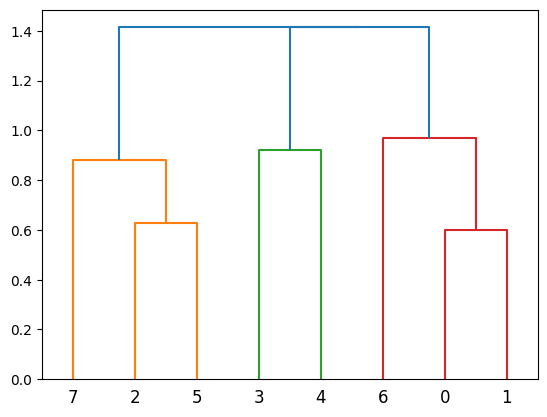

In [47]:
from scipy.cluster import hierarchy 
Z = hierarchy.linkage(tv_matrix, 'complete')
dendro = hierarchy.dendrogram(Z)